# Example of using nuscenes with detectron2

### Import libs

In [1]:
from nusc_conv.conv import get_nuscenes_dicts
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt

%matplotlib inline
import random
import torch
import cv2

### Select categories of intetrest 
[List of all categories](https://www.nuscenes.org/data-annotation)

In [2]:
categories = ['human.pedestrian.adult',
              'human.pedestrian.child',
              'human.pedestrian.wheelchair',
              'human.pedestrian.stroller',
              'human.pedestrian.personal_mobility',
              'human.pedestrian.police_officer',
              'human.pedestrian.construction_worker',
              'vehicle.car',
              'vehicle.bus.bendy',
              'vehicle.bus.rigid',
              'vehicle.truck',
              'vehicle.construction',
              'vehicle.emergency.ambulance',
              'vehicle.emergency.police',
              'vehicle.trailer']

### Register nuScenes dataset for detector2
For registration we need a function that create dict from data annotation (format dict see [here]( https://detectron2.readthedocs.io/tutorials/datasets.html))

In [3]:
# Create function instance from get_nuscences_dicts(path, categories) with variable parameters
path = "/path/to/nuScence/folder/"
path = "./v1-mini/"
get_dicts = lambda p=path, c=categories: get_nuscenes_dicts(path=p, categories=c)
# Register dataset as nusc_mini
DatasetCatalog.register("nusc_mini", get_dicts)
# Register metadat (label names) as nusc_mini
MetadataCatalog.get("nusc_mini").thing_classes = categories

### Predicting

Set default model for predicting

In [4]:
# Set model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
if (not torch.cuda.is_available()):
    cfg.MODEL.DEVICE = "cpu" 
predictor = DefaultPredictor(cfg)
# Define dict with dataset and annotation for bbox
dataset_dicts = get_dicts()
nusc_metadata = MetadataCatalog.get("nusc_mini")

100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Predict \
By default - bbox from dataset, segmentation from predicting model

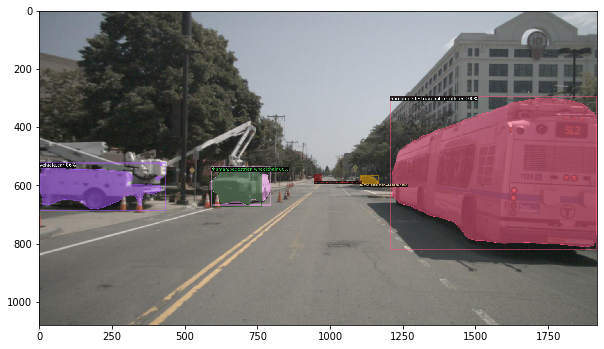

In [6]:
# Get 1 random sample
sample = random.sample(dataset_dicts, 1)[0]
img = cv2.imread(sample["file_name"])
# Predict
outputs = predictor(img)
# Visualisation
v = Visualizer(img[:, :, ::-1], nusc_metadata, scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))